In [1]:
using SparseArrays
using LinearAlgebra
using NLopt
using KrylovKit
using Statistics
using FiniteDifferences
using Revise
using TopologyOptimizationHelper

In [2]:
using PyPlot
using DelimitedFiles

In [279]:
function log_LDOS_Optimize(L, ε, ω, b; dpml=0.5, resolution=20, Rpml=1e-20, ftol=1e-4, max_eval=500, design_width=L, fixed_width=0, alg=:LD_CCSAQ)
    A, x = Maxwell1d(L, ε, ω; dpml, resolution, Rpml)
    D² = A + spdiagm(ω^2 .* ε)
    M = length(x)
    log_LDOS_vals = Float64[]
    log_omegas = ComplexF64[]
    iter = 1
    
    function log_LDOS_obj(ε, grad)
        A = D² - ω^2 * spdiagm(ε)
        LDOS, ∇LDOS = ∇_ε_LDOS(A, ω, b)
        log_LDOS = log(LDOS)

        if !isempty(grad) 
            grad .= ∇LDOS / LDOS        
        end
        
        push!(log_LDOS_vals, log_LDOS)

        A_now, _ = Maxwell1d(L, ε, ω; resolution, dpml, Rpml)
        ω₀_now = sqrt(Arnoldi_eig(A_now, ε, ω, b)[1])
        push!(log_omegas, ω₀_now)

        if iter % 100 == 0
            @show iter, LDOS
        end

        iter += 1
        
        return log_LDOS
    end

    design_indices = (-design_width/2 .< x .- mean(x) .< design_width/2) .& .!(-fixed_width/2 .< x .- mean(x) .< fixed_width/2)
    ub = copy(ε)
    lb = copy(ε)
    ub[design_indices] .= 12
    lb[design_indices] .= 1
    
    opt = Opt(alg, M)
    # opt.params["verbosity"] = 1
    opt.lower_bounds = lb
    opt.upper_bounds = ub
    opt.ftol_rel = ftol
    opt.ftol_abs = ftol
    opt.xtol_rel = ftol
    opt.xtol_abs = ftol
    opt.maxeval = max_eval
    opt.max_objective = log_LDOS_obj

    (log_LDOS_opt, log_ε_opt, ret) = optimize(opt, ε)
    A_opt, _ = Maxwell1d(L, log_ε_opt, ω; resolution, dpml, Rpml)
    ω₀_opt = sqrt(Arnoldi_eig(A_opt, log_ε_opt, ω, b)[1])
    Q_opt = -real(ω₀_opt) / 2imag(ω₀_opt)

    @show numevals = opt.numevals # the number of function evaluations
    @show ω₀_opt
    @show Q_opt
    @show ret
    
    return log_LDOS_opt, log_ε_opt, log_LDOS_vals, log_omegas, x
end

log_LDOS_Optimize (generic function with 1 method)

In [280]:
function mod_log_LDOS_Optimize(L, ε, ω, b, x₀; dpml=0.5, resolution=20, Rpml=1e-20, ftol=1e-4, max_eval=500, ω_pml=ω, design_width=L, alg=:LD_CCSAQ)
    A, x = Maxwell1d(L, ε, ω; dpml, resolution, Rpml)
    D² = A + ω^2 .* spdiagm(ε)
    M = length(x)
    log_LDOS_vals = Float64[]
    log_omegas = ComplexF64[]

    iter = 1
    LDOS_curr = 0.0
    function mod_log_LDOS_obj(ε, grad)
        E = spdiagm(ε)
        E⁻¹ = spdiagm(1 ./ ε)
        A = D² - ω^2 .* E
        C = E⁻¹ * A
        LU = lu(C)
        vals, vecs, _ = eigsolve(z -> LU \ z, x₀, 1, :LM, Arnoldi())
        vals = sqrt.(1 ./ vals .+ ω^2)
        ω₀, u₀ = vals[1], vecs[1]
        A₀ = D² - real(ω₀)^2 .* E
        v = A₀ \ b
        w = conj.(v)
        LDOS = -imag(v' * b)
        log_LDOS = log(LDOS)
        ∂LDOS_∂ω = -2real(ω₀) * imag(v' * E * w)

        if !isempty(grad) 
            ∂ω_∂ε = -ω₀ .* u₀.^2 ./ 2sum(u₀.^2 .* ε)
            ∂LDOS_∂ε = real(ω₀)^2 * imag.(v.^2)
            ∇LDOS = ∂LDOS_∂ε .+  ∂LDOS_∂ω .* real.(∂ω_∂ε)
            grad .= ∇LDOS / LDOS
        end

        push!(log_LDOS_vals, log_LDOS)
        push!(log_omegas, ω₀)
        
        if iter % 100 == 0
            @show iter, LDOS
        end
        
        iter += 1
        LDOS_curr = LDOS
        return log_LDOS
    end

    function freq_constraint(ε, grad)        
        ω₀, ∂ω_∂ε = Eigengradient(A, ε, ω, x₀)
        # if !isempty(grad) 
        #     grad .= -real.(∂ω_∂ε) / ω 
        # end

        # return 1 - real(ω₀) / ω

        if !isempty(grad) 
            grad .= -real.(∂ω_∂ε)
        end

        return  ω - real(ω₀)

    end

    design_indices = -design_width / 2 .< x .- mean(x) .< design_width / 2
    ub = ones(M)
    ub[design_indices] .= 12
    
    opt = Opt(alg, M)
    # opt.params["verbosity"] = 1
    opt.lower_bounds = 1
    opt.upper_bounds = ub
    opt.ftol_rel = ftol
    opt.ftol_abs = ftol
    opt.xtol_rel = ftol
    opt.xtol_abs = ftol
    opt.maxeval = max_eval
    opt.max_objective = mod_log_LDOS_obj
    opt.initial_step = 1e-1
    # inequality_constraint!(opt, freq_constraint)


    (log_LDOS_opt, log_ε_opt, ret) = optimize(opt, ε)
    ω₀ = log_omegas[end]
    Q = -real(ω₀) / 2imag(ω₀)

    @show numevals = opt.numevals # the number of function evaluations
    @show ω₀
    @show Q
    @show ret
    
    return log_LDOS_opt, log_ε_opt, log_LDOS_vals, log_omegas, x
end

mod_log_LDOS_Optimize (generic function with 1 method)

In [281]:
L = 5
res = 50
ε = ones(res * (L + 1))

M = length(ε) 
ω = 2π
_, x = Maxwell1d(L, ε, ω; resolution=res)

b = zeros(M)
b[M÷2] = 1;

In [282]:
ε_vac = ones(M)
A_vac, _ = Maxwell1d(L, ε_vac, ω; resolution=res)
u = A_vac \ b
@show LDOS_vac = -imag(u' * b)

LDOS_vac = -(imag(u' * b)) = 0.0015894422269321887


0.0015894422269321887

In [283]:
custom_epsilon = Fabry_Perot_epsilon.(L, x; λ=1)
A, _ = Maxwell1d(L, custom_epsilon, ω; resolution=res)
ω₀ = sqrt(Arnoldi_eig(A, custom_epsilon, ω, b)[1])
@show Q_fp = -real(ω₀) / 2imag(ω₀)

Q_fp = -(real(ω₀)) / (2 * imag(ω₀)) = 3.9663413059790134e7


3.9663413059790134e7

In [284]:
LDOS_init, ε_init, init_LDOS_vals, init_omegas, x = log_LDOS_Optimize(L, ε, ω, b; resolution=res, ftol=0, max_eval=200, alg=:LD_CCSAQ)

(iter, LDOS) = (100, 0.5698313392261173)
(iter, LDOS) = (200, 5.660000396211323)
numevals = opt.numevals = 200
ω₀_opt = 6.283189483633811 - 0.00029804921326253615im
Q_opt = 10540.523517670343
ret = :MAXEVAL_REACHED


(1.7334239622170895, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [-6.444372124966526, -7.081880244654986, -7.3060229231399925, -5.921458317616547, -5.482508141667833, -6.082537612669413, -5.285758172895155, -4.651187884583259, -7.574577028584068, -6.716796904117968  …  1.7185413390575763, 1.5283261281217042, 1.7220000059117198, 1.7300611558533363, 1.461376327977108, 1.7161504826753693, 1.731808959724245, 0.8052594516411131, 1.7252610273371929, 1.7334239622170895], ComplexF64[5.764179529542722 - 2.1834196863707422im, 6.2624622718047585 - 0.09931763879737113im, 6.646046896754592 - 0.19581487275866052im, 6.049571006399429 - 0.2616991178839609im, 6.328108399517975 - 0.27778080499412455im, 6.015745993884492 - 0.1519588985820529im, 6.226479568999578 - 0.22905095543480053im, 6.212494990962934 - 0.10162142325377621im, 6.491259081525111 - 0.02712576468900181im, 6.585969731472339 - 0.1235040014351292im  …  6.28320446270086 - 0.00030125

In [285]:
mod_LDOS_opt, mod_ε_opt, mod_LDOS_vals, mod_omegas, x = mod_log_LDOS_Optimize(L, ε_init, ω, b, b; ftol=0, resolution=res, max_eval=2000, alg=:LD_TNEWTON)

(iter, LDOS) = (100, 5.6672774887971675)
(iter, LDOS) = (200, 5.68016464129567)
(iter, LDOS) = (300, 11.19293048942703)
(iter, LDOS) = (400, 26.01751003877085)
(iter, LDOS) = (500, 0.008110402541221086)
(iter, LDOS) = (600, 49.48285379338976)
(iter, LDOS) = (700, 49.491692635225675)
(iter, LDOS) = (800, 0.008125377171176064)
(iter, LDOS) = (900, 0.008458769290858686)
(iter, LDOS) = (1000, 49.506830384696464)
(iter, LDOS) = (1100, 0.008462140954438199)
(iter, LDOS) = (1200, 0.008462022566361483)
(iter, LDOS) = (1300, 0.008462022567544055)
(iter, LDOS) = (1400, 0.00846202366600179)
(iter, LDOS) = (1500, 0.008462022567803491)
(iter, LDOS) = (1600, 0.008462023666023734)
numevals = opt.numevals = 1673
ω₀ = 5.749612639352118 - 5.408299572641767e-5im
Q = 53155.456369659194
ret = :FAILURE


(3.902111182965727, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.73363247799964, 1.733632522095143, 1.733632507522928, 1.7336325864501685, 1.733632629776831, 1.73363261598392, 1.733633415167377, 1.7336334583020938, 1.7336334444393455, 1.733634925534636  …  -4.7707678460476375, -4.77215306639537, -4.772166929946519, -4.772167068583129, -4.772167069969803, 3.9021111829656583, 3.902111182965694, 3.9021111829656467, 3.902111182965727, 3.902111182965727], ComplexF64[6.283189483637589 - 0.00029804921318138497im, 6.2831894787385885 - 0.0002980492026715843im, 6.283189485478007 - 0.00029804920701352545im, 6.283189471782657 - 0.00029804918725959774im, 6.283189466775873 - 0.00029804917700831696im, 6.283189473099032 - 0.00029804918103719814im, 6.283189376017091 - 0.0002980489911814136im, 6.283189370982992 - 0.00029804898099257507im, 6.283189377441264 - 0.000298048985072752im, 6.2831891997470635 - 0.0002980486344177381im  …  6.774845351

In [263]:
mod_LDOS_opt, mod_ε_opt, mod_LDOS_vals, mod_omegas, x = mod_log_LDOS_Optimize(L, mod_ε_opt, ω, b, b; ftol=0, resolution=res, max_eval=1000, alg=:LD_LBFGS)

numevals = opt.numevals = 34
ω₀ = 5.749612639346566 - 5.4082995725950526e-5im
Q = 53155.456370067
ret = :FAILURE


(3.902111182976504, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [3.9021111829762596, -4.799921170085109, -4.772440375235907, -4.772169802596498, -4.772167097309046, -4.772167070256153, -4.7721670699861605, 3.9021111829762427, 3.9021111829762765, -4.904018998179148  …  -4.772440375235995, -4.77216980259669, -4.772167097309195, -4.772167070256119, -4.772167069986155, 3.902111182976432, 3.9021111829764736, 3.902111182976476, 3.902111182976504, 3.902111182976504], ComplexF64[5.749612639346684 - 5.4082995725953196e-5im, 6.774065764325001 - 0.0014838327855186317im, 6.77485443110129 - 0.0015025643929660738im, 6.774862259676711 - 0.0015027530517828056im, 6.774862337956866 - 0.0015027549385099065im, 6.774862338739671 - 0.001502754957377177im, 6.774862338747496 - 0.0015027549575658472im, 5.749612639346629 - 5.408299572594863e-5im, 5.749612639346677 - 5.4082995726004926e-5im, 6.772585558577669 - 0.0014546219671638936im  …  6.77485443110

In [197]:
A, x = Maxwell1d(L, ε_init, ω; resolution=res)
@show ω₀_init = sqrt(Arnoldi_eig(A, vec(ε_init), ω, vec(b))[1])
E⁻¹ = spdiagm(1 ./ vec(ε_init))
vals, vecs, info = eigsolve(z -> E⁻¹ * A * z + ω^2 .* z, vec(b), 1, EigSorter(λ -> abs(λ - ω₀_init^2); rev = false), Arnoldi()) 
u_init = abs.(vecs[1]).^2

A, x = Maxwell1d(L, mod_ε_opt, ω; resolution=res)
@show mod_ω₀_opt = sqrt(Arnoldi_eig(A, vec(mod_ε_opt), ω, vec(b))[1])
E⁻¹ = spdiagm(1 ./ vec(mod_ε_opt))
vals, vecs, info = eigsolve(z -> E⁻¹ * A * z + ω^2 .* z, vec(b), 1, EigSorter(λ -> abs(λ - mod_ω₀_opt^2); rev = false), Arnoldi()) 
mod_u_opt = abs.(vecs[1]).^2

true_max = maximum(vcat(u_init, mod_u_opt));

ω₀_init = sqrt((Arnoldi_eig(A, vec(ε_init), ω, vec(b)))[1]) = 4.31370452792036 - 0.0007672551766083676im
mod_ω₀_opt = sqrt((Arnoldi_eig(A, vec(mod_ε_opt), ω, vec(b)))[1]) = 4.652632228635266 - 9.346281105648195e-7im


┌ Warning: Arnoldi eigsolve stopped without convergence after 100 iterations:
│ * 0 eigenvalues converged
│ * norm of residuals = (2.03e+00)
│ * number of operations = 1218
└ @ KrylovKit C:\Users\jorge\.julia\packages\KrylovKit\jC5gU\src\eigsolve\arnoldi.jl:172
┌ Warning: Arnoldi eigsolve stopped without convergence after 100 iterations:
│ * 0 eigenvalues converged
│ * norm of residuals = (6.82e-03)
│ * number of operations = 1218
└ @ KrylovKit C:\Users\jorge\.julia\packages\KrylovKit\jC5gU\src\eigsolve\arnoldi.jl:172


In [198]:
rc("font", family="serif", serif="Times New Roman")
rc("mathtext", fontset="cm")
rc("xtick", labelsize=11.5)  # x-axis tick labels
rc("ytick", labelsize=12)  # y-axis tick labels

sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


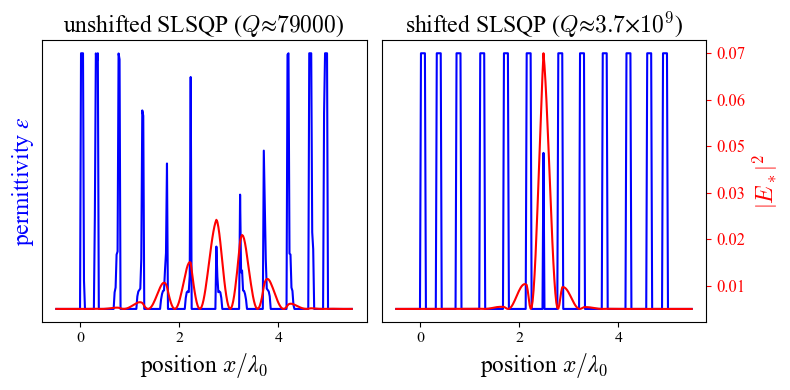

In [199]:
figure(figsize=(8, 4))

subplot(1, 2, 1)
plot(x, ε_init, "b-")
plot(x, (11/true_max)u_init .+ 1, color="red")
title(L"initialization ($Q ≈ 79000$)", fontsize=17)
ylabel(L"permittivity $ε$", color="blue", fontsize=17)
gca().tick_params(axis="y", colors="blue")
xlabel(L"position $x / λ_0$", fontsize=17)

# Bar height
# bar_h = 0.4
# plot([2.7, 2.7], [10 - bar_h/2, 10 + bar_h/2], "k-", lw=1.5)
# plot([5, 5], [10 - bar_h/2, 10 + bar_h/2], "k-", lw=1.5)

# Text under the line
yticks([])
title(L"unshifted SLSQP ($Q ≈ 79000$)", fontsize=17)
xlabel(L"position $x / λ_0$", fontsize=17)

subplot(1, 2, 2)
plot(x, mod_ε_opt, color="blue")
plot(x, (11/true_max)mod_u_opt .+ 1, color="red")
# Main horizontal line
# plot([2.7, 5], [10, 10], "k-")

# Bar height
bar_h = 0.4

# Vertical bars at ends
# plot([2.7, 2.7], [10 - bar_h/2, 10 + bar_h/2], "k-", lw=1.5)
# plot([5, 5], [10 - bar_h/2, 10 + bar_h/2], "k-", lw=1.5)
# text((2.7 + 5)/2, 10 - bar_h, "6 layers", ha="center", va="top", bbox=Dict("facecolor"=>"white", "edgecolor"=>"black", "pad"=>3.2), fontsize=16)

ylabel(L"$\left|E_*\right|^2$", color="red", fontsize=17)
gca().tick_params(axis="y", colors="red")
gca().yaxis.tick_right()        # move ticks to the right
gca().yaxis.set_label_position("right")  # move label to the right
ytick = gca().get_yticks()
gca().set_yticklabels(string.(round.(true_max .* (ytick .- 1) ./ 11; digits=2)))
title(L"shifted SLSQP ($Q ≈ 3.7×10^9$)", fontsize=17)
xlabel(L"position $x / λ_0$", fontsize=17)

tight_layout()

In [94]:
LDOS_us, ε_us, us_LDOS_vals, us_omegas, x = log_LDOS_Optimize(L, ε_init, ω, b; resolution=res, ftol=0, max_eval=1000, alg=:LD_TNEWTON)

(iter, LDOS) = (100, 75.68091113243328)
(iter, LDOS) = (200, 75.68335712279702)
(iter, LDOS) = (300, 75.68336005678499)
(iter, LDOS) = (400, 75.68336295810643)
(iter, LDOS) = (500, 75.68336579712208)
(iter, LDOS) = (600, 75.68336873831542)
(iter, LDOS) = (700, 75.68337163983186)
(iter, LDOS) = (800, 75.68337447977365)
(iter, LDOS) = (900, 75.6833774257532)
(iter, LDOS) = (1000, 75.68338033409141)
numevals = opt.numevals = 1002
ω₀_opt = 6.283185298349039 - 3.99225637024408e-5im
Q_opt = 78692.15696141397
ret = :MAXEVAL_REACHED


(4.3265585905395225, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [4.3255183412945195, 4.325523400536031, 4.325524110961359, 4.325528129000229, 4.325528148125134, 4.3255314352268845, 4.3255322443886115, 4.325535082295075, 4.325538111541227, 4.325540603962559  …  4.326558587092361, 4.326558587596171, 4.3265585872185515, 4.326558588241238, 4.326558588366912, 4.326558588367435, 4.3265585893904035, 4.326558589894263, 4.326558589516605, 4.3265585905395225], ComplexF64[6.2831847592405285 - 3.995684327817395e-5im, 6.283184766736402 - 3.99568441654865e-5im, 6.283184767797883 - 3.995684429682558e-5im, 6.283184773829566 - 3.9956844861878396e-5im, 6.283184773860424 - 3.995684490032079e-5im, 6.283184778838021 - 3.995684521484186e-5im, 6.283184780072645 - 3.9956845332672285e-5im, 6.283184784413131 - 3.9956845504820144e-5im, 6.283184789082357 - 3.995684558783521e-5im, 6.283184792958323 - 3.995684572213008e-5im  …  6.283185299702212 - 3.9922

In [101]:
LDOS_s, ε_s, s_LDOS_vals, s_omegas, x = mod_log_LDOS_Optimize(L, mod_ε_opt, ω, b, b; resolution=res, ftol=0, max_eval=1000, alg=:G_MLSL)

LoadError: BoundsError: attempt to access 0-element Vector{ComplexF64} at index [0]